In [1]:
import pyusbus
 
import numpy as np 
import matplotlib.pyplot as plt

# Figures
import numpy as np
# Utilities
import json
import base64
import struct
import time 
import matplotlib.pyplot as plt
import cv2

import usb.core
import usb.util

In /home/kelu/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/kelu/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/kelu/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/kelu/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/kelu/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_c

# Initialize the probe

In [2]:
probe = pyusbus.Doppler();

paVaWgIAAAAAAAAAAAAAAAQABgAAAAAAAgAAAFpapaUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA=
paVaWgIAWloAAAAAAAAAAAkABgABAAAAAgClpVpapaUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA

Reset done
512
512
1024
1024
512
1024
2560
1536
512
512
512


# Read a few frames and creates the loop

In [15]:
probe.getImages(n=1)

1

In [16]:
IMG = probe.createLoop()

Text(0.5, 1.0, 'f')

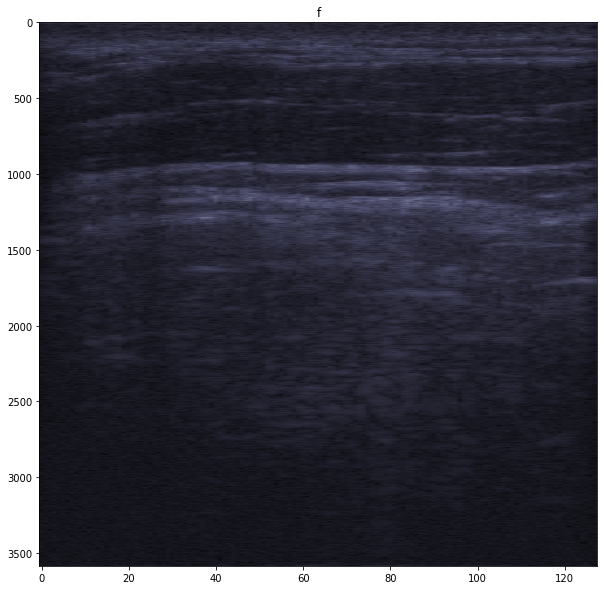

In [17]:
plt.figure(figsize=(10,10))
plt.imshow(np.sqrt(np.sqrt(np.abs(probe.loop[0])).T), aspect='auto', cmap='bone')
plt.title("f")